# with H

In [1]:
import io
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
from itertools import permutations

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # has wide Unicode support

# Base directories
BASE_DIR = Path("/Users/wenlanzhang/PycharmProjects/Mapineq/src/")
DATA_DIR = Path("/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford")

# Load Data

##  Meta SCI - VE missing
Source: https://data.humdata.org/dataset/social-connectedness-index

In [9]:
df_SCI = pd.read_csv(DATA_DIR/f"Migration/Excess/countries-countries-fb-social-connectedness-index-october-2021.tsv", sep="\t") 
# df_pop = df_pop[['Country Code', '2019', '2020', '2021', '2022']]
df_SCI

,user_loc,fr_loc,scaled_sci
0,AE,AE,1117179
1,AE,AG,5488
2,AE,AL,2101
3,AE,AM,3580
4,AE,AO,2326
...,...,...,...
34220,ZW,XK,262
34221,ZW,YT,1650
34222,ZW,ZA,366466
34223,ZW,ZM,196035


In [11]:
# Collect all unique country codes from SCI
sci_countries = set(df_SCI["user_loc"].unique()) | set(df_SCI["fr_loc"].unique())

# Collect all unique country codes from migration data
migration_countries = set(df["country_from"].unique()) | set(df["country_to"].unique())

# Countries in SCI but not in migration
missing_in_migration = sci_countries - migration_countries

# Countries in migration but not in SCI
missing_in_sci = migration_countries - sci_countries

print("Countries in SCI but missing in migration:")
print(sorted(missing_in_migration))

print("\nCountries in migration but missing in SCI:")
print(sorted(missing_in_sci))

Countries in SCI but missing in migration:
['AG', 'AW', 'CW', 'GF', 'GP', 'GU', 'IM', 'JE', 'KY', 'MQ', 'NC', 'PF', 'PR', 'RE', 'SC', 'YT']

Countries in migration but missing in SCI:
['AD', 'AF', 'ER', 'IL', 'IQ', 'RU', 'SD', 'SS', 'SY', 'TM', 'VE', 'YE']


## Meta Migration 

In [3]:
df = pd.read_csv(DATA_DIR/f"Migration/international_migration_flow.csv") 
df['year'] = pd.to_datetime(df['migration_month']).dt.year
df['month'] = pd.to_datetime(df['migration_month']).dt.month
df["migration_month"] = pd.to_datetime(df["migration_month"])

# Unique list from both columns
unique_countries = pd.unique(df[["country_from", "country_to"]].values.ravel())

df

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01-01,12,2019,1
1,AD,AE,2019-02-01,2,2019,2
2,AD,AE,2019-03-01,1,2019,3
3,AD,AE,2019-04-01,7,2019,4
4,AD,AE,2019-05-01,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138,2022,8
1563150,ZW,ZM,2022-09-01,162,2022,9
1563151,ZW,ZM,2022-10-01,149,2022,10
1563152,ZW,ZM,2022-11-01,104,2022,11


In [4]:
# Keep only what we need and rename to the model’s expected names
df_flow = (df
      .rename(columns={
          "country_from": "orig",
          "country_to": "dest",
          # "migration_month": "month",
          "num_migrants": "flow"
      })
      [["orig", "dest", "migration_month", "flow"]].copy()).rename(columns={
          "migration_month": "month"      })

# Make sure month is monthly datetime (month-start)
# df_flow["month"] = pd.to_datetime(df["month"]).dt.to_period("M").dt.to_timestamp()

# Clean types
df_flow["orig"] = df_flow["orig"].astype(str).str.upper()
df_flow["dest"] = df_flow["dest"].astype(str).str.upper()
df_flow["flow"] = pd.to_numeric(df_flow["flow"], errors="coerce").fillna(0).clip(lower=0).astype(int)

# If there are accidental duplicates (same orig-dest-month), aggregate
# df_flow = (df_flow.groupby(["orig", "dest", "month"], as_index=False)["flow"].sum())

df_flow

,orig,dest,month,flow
0,AD,AE,2019-01-01,12
1,AD,AE,2019-02-01,2
2,AD,AE,2019-03-01,1
3,AD,AE,2019-04-01,7
4,AD,AE,2019-05-01,0
...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138
1563150,ZW,ZM,2022-09-01,162
1563151,ZW,ZM,2022-10-01,149
1563152,ZW,ZM,2022-11-01,104


## Country alpha2/3

In [5]:
df_country = pd.read_csv(DATA_DIR/f"all.csv") 
df_country = df_country[['name', 'alpha-2', 'alpha-3', 
                         'region', 'sub-region']]

df_country = df_country[df_country["alpha-2"].isin(unique_countries)]
df_country

,name,alpha-2,alpha-3,region,sub-region
0,Afghanistan,AF,AFG,Asia,Southern Asia
2,Albania,AL,ALB,Europe,Southern Europe
3,Algeria,DZ,DZA,Africa,Northern Africa
5,Andorra,AD,AND,Europe,Southern Europe
6,Angola,AO,AGO,Africa,Sub-Saharan Africa
...,...,...,...,...,...
240,"Venezuela, Bolivarian Republic of",VE,VEN,Americas,Latin America and the Caribbean
241,Viet Nam,VN,VNM,Asia,South-eastern Asia
246,Yemen,YE,YEM,Asia,Western Asia
247,Zambia,ZM,ZMB,Africa,Sub-Saharan Africa


## Population 
Source: World Bank  
https://data.worldbank.org/indicator/SP.POP.TOTL

In [6]:
df_pop = pd.read_csv(DATA_DIR/f"Migration/Excess/API_SP.POP.TOTL_DS2_en_csv_v2_710977.csv") 
df_pop = df_pop[['Country Code', '2019', '2020', '2021', '2022']]
df_pop

# source: https://data.worldbank.org/indicator/SP.POP.TOTL

,Country Code,2019,2020,2021,2022
0,ABW,109203.0,108587.0,107700.0,107310.0
1,AFE,675950189.0,694446100.0,713090928.0,731821393.0
2,AFG,37856121.0,39068979.0,40000412.0,40578842.0
3,AFW,463365429.0,474569351.0,485920997.0,497387180.0
4,AGO,32375632.0,33451132.0,34532429.0,35635029.0
...,...,...,...,...,...
261,XKX,1788891.0,1790151.0,1786079.0,1768096.0
262,YEM,35111408.0,36134863.0,37140230.0,38222876.0
263,ZAF,59587885.0,60562381.0,61502603.0,62378410.0
264,ZMB,18513839.0,19059395.0,19603607.0,20152938.0


In [7]:
# Make a mapping dictionary: alpha-3 → alpha-2
alpha_map = dict(zip(df_country["alpha-3"], df_country["alpha-2"]))

# Map alpha-3 to alpha-2
df_pop["Country Code"] = df_pop["Country Code"].map(alpha_map)

# Drop rows where mapping failed (NaN values in Country Code)
df_pop = df_pop.dropna(subset=["Country Code"]).reset_index(drop=True)

df_pop

,Country Code,2019,2020,2021,2022
0,AF,37856121.0,39068979.0,40000412.0,40578842.0
1,AO,32375632.0,33451132.0,34532429.0,35635029.0
2,AL,2854191.0,2837849.0,2811666.0,2777689.0
3,AD,76474.0,77380.0,78364.0,79705.0
4,AE,9445785.0,9401038.0,9575152.0,10074977.0
...,...,...,...,...,...
173,WS,209780.0,211944.0,213779.0,215261.0
174,YE,35111408.0,36134863.0,37140230.0,38222876.0
175,ZA,59587885.0,60562381.0,61502603.0,62378410.0
176,ZM,18513839.0,19059395.0,19603607.0,20152938.0


In [8]:
# Convert to long format
df_pop_long = df_pop.melt(id_vars=["Country Code"], 
                  var_name="Year", 
                  value_name="Population")

# After melting into long format (df_long)
df_pop_long = df_pop_long.rename(columns={
    "Country Code": "iso3",
    "Year": "year",
    "Population": "population"
})

df_pop_long

,iso3,year,population
0,AF,2019,37856121.0
1,AO,2019,32375632.0
2,AL,2019,2854191.0
3,AD,2019,76474.0
4,AE,2019,9445785.0
...,...,...,...
707,WS,2022,215261.0
708,YE,2022,38222876.0
709,ZA,2022,62378410.0
710,ZM,2022,20152938.0


## Prep

In [9]:
# Get unique country codes from both datasets
pop_codes = set(df_pop["Country Code"].unique())
flow_codes = set(df_flow["orig"].unique()) | set(df_flow["dest"].unique())

# Find differences
missing_in_pop = flow_codes - pop_codes
missing_in_flow = pop_codes - flow_codes

print("✅ Country codes in flow but missing in pop:")
print(missing_in_pop if missing_in_pop else "None")

print("\n✅ Country codes in pop but missing in flow:")
print(missing_in_flow if missing_in_flow else "None")

✅ Country codes in flow but missing in pop:
{'NAN', 'TW', 'XK'}

✅ Country codes in pop but missing in flow:
None


In [10]:
print("✅ Before cleaning:", len(df_flow))

# Allowed country codes (from df_pop)
valid_codes = set(df_pop["Country Code"].unique())

# Keep only rows where both orig and dest are in df_pop
df_flow = df_flow[
    df_flow["orig"].isin(valid_codes) & df_flow["dest"].isin(valid_codes)
].copy()

print("✅ After cleaning:", len(df_flow))

✅ Before cleaning: 1563154
✅ After cleaning: 1511698


## Smaller Set 

### Latin America countries

In [11]:
# selected_countries = ["VE", "CL", "US", "EC", "CO"]  # 2-letter ISO codes

selected_countries = [
    # South America
    'AR',  # Argentina
    'BO',  # Bolivia
    'BR',  # Brazil
    'CL',  # Chile
    'CO',  # Colombia
    'EC',  # Ecuador
    'GY',  # Guyana
    'PY',  # Paraguay
    'PE',  # Peru
    'SR',  # Suriname
    'UY',  # Uruguay
    'VE',  # Venezuela

    # # Central America
    # 'BZ',  # Belize
    'CR',  # Costa Rica
    # 'SV',  # El Salvador
    # 'GT',  # Guatemala
    # 'HN',  # Honduras
    'NI',  # Nicaragua
    'PA',  # Panama

    # Mexico
    'MX',  # Mexico

    # Caribbean (Latin)
    'CU',  # Cuba
    'DO',  # Dominican Republic
    'PR',  # Puerto Rico (US territory but culturally Latin)
    'HT',  # Haiti (French/Creole-speaking, sometimes included)

    # Manually add US & CA
    'US','CA','ES'
]

# 1️⃣ Filter population data
pops_filtered = df_pop_long[df_pop_long['iso3'].isin(selected_countries)].copy()

# Optional: check
print("Filtered population data:")
pops_filtered

Filtered population data:


,iso3,year,population
5,AR,2019,44973465.0
21,BO,2019,11671386.0
22,BR,2019,207455459.0
28,CA,2019,37618495.0
30,CL,2019,19197744.0
...,...,...,...
666,PY,2022,6760464.0
681,SR,2022,623164.0
700,UY,2022,3390913.0
701,US,2022,334017321.0


### European countries

In [11]:
selected_countries = [
    # European Union (EU) - Northern Europe
    'DK',  # Denmark
    'EE',  # Estonia
    'FI',  # Finland
    'IE',  # Ireland
    'LV',  # Latvia
    'LT',  # Lithuania
    'SE',  # Sweden

    # European Union (EU) - Western Europe
    'AT',  # Austria
    'BE',  # Belgium
    'FR',  # France
    'DE',  # Germany
    'LU',  # Luxembourg
    'NL',  # Netherlands

    # European Union (EU) - Southern Europe
    'HR',  # Croatia
    'CY',  # Cyprus
    'GR',  # Greece
    'IT',  # Italy
    'MT',  # Malta
    'PT',  # Portugal
    'SI',  # Slovenia
    'ES',  # Spain

    # # European Union (EU) - Central & Eastern Europe
    # 'BG',  # Bulgaria
    # 'CZ',  # Czechia (Czech Republic)
    # 'HU',  # Hungary
    # 'PL',  # Poland
    # 'RO',  # Romania
    # 'SK',  # Slovakia

    # # European Union (EU) - Recent Members
    # 'HR',  # Croatia (joined 2013)
]
# 1️⃣ Filter population data
pops_filtered = df_pop_long[df_pop_long['iso3'].isin(selected_countries)].copy()

# Optional: check
print("Filtered population data:")
pops_filtered

Filtered population data:


,iso3,year,population
8,AT,2019,8879920.0
11,BE,2019,11488980.0
39,CY,2019,1286671.0
41,DE,2019,83092962.0
43,DK,2019,5814422.0
...,...,...,...
642,MT,2022,531113.0
654,NL,2022,17700982.0
665,PT,2022,10434332.0
683,SI,2022,2112076.0


## Set flow 

In [12]:
# 2️⃣ Filter flows data (both orig and dest must be in selected countries)
flows_filtered = df_flow[
    df_flow['orig'].isin(selected_countries) & df_flow['dest'].isin(selected_countries)
].copy()

print("\nFiltered flow data:")
flows_filtered


Filtered flow data:


,orig,dest,month,flow
52750,AR,BO,2019-01-01,3325
52751,AR,BO,2019-02-01,3275
52752,AR,BO,2019-03-01,2686
52753,AR,BO,2019-04-01,2089
52754,AR,BO,2019-05-01,2084
...,...,...,...,...
1493597,VE,UY,2022-08-01,122
1493598,VE,UY,2022-09-01,121
1493599,VE,UY,2022-10-01,161
1493600,VE,UY,2022-11-01,149


In [13]:
# df_flow.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/df_flow.csv", index=False)

# Check Data

In [15]:
from cf_plus_Copy1 import diagnose_inputs
from cf_plus_Copy1 import compute_global_moy_baseline, compute_global_shock_index

In [16]:
report = diagnose_inputs(df_flow, df_pop_long)
report

,value
flows_min_month,2019-01-01 00:00:00
flows_max_month,2022-12-01 00:00:00
n_rows_flows,1511698
n_pairs,31496
rows_year_2019,377921
rows_year_2020,377923
rows_year_2021,377926
rows_year_2022,377928
pop_cols,"iso3,population,year"
n_countries_flows,178


In [17]:
# Optional: Sanity checks that avoid NaNs and bad splits

# Make sure baseline years exist (or adjust baseline_years)
print(df_flow['month'].min(), df_flow['month'].max())
print(df_pop_long[['iso3','year']].drop_duplicates().head())

2019-01-01 00:00:00 2022-12-01 00:00:00
  iso3  year
0   AF  2019
1   AO  2019
2   AL  2019
3   AD  2019
4   AE  2019


#  Counterfactual

In [13]:
# Selected data
flows = flows_filtered
pops = pops_filtered

# Full data
# flows = df_flow
# pops = df_pop_long

# Sample data
# flows = pd.read_csv("flows_sample.csv")     # orig, dest, month, flow
# pops  = pd.read_csv("pops_sample.csv")      # iso3, year, population

pops

,iso3,year,population
5,AR,2019,44973465.0
21,BO,2019,11671386.0
22,BR,2019,207455459.0
28,CA,2019,37618495.0
30,CL,2019,19197744.0
...,...,...,...
666,PY,2022,6760464.0
681,SR,2022,623164.0
700,UY,2022,3390913.0
701,US,2022,334017321.0


| Parameter                | Type / Example                          |                                         Default | What it controls                                                                           | When to change                                                                                     |
| ------------------------ | --------------------------------------- | ----------------------------------------------: | ------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------- |
| `train_end`              | `str` date, e.g. `"2021-12-01"`         |                                  `"2021-12-01"` | Last month included in training (inclusive).                                               | Set to the end of your intended training window. Ensure your data covers it.                       |
| `val_start`              | `str` date, e.g. `"2021-07-01"`         |                                  `"2021-07-01"` | Start of the **validation slice** inside training, used to pick `alpha`.                   | Use a late subset (last 6–12 months of training). If too short, the code falls back automatically. |
| `baseline_years`         | `tuple[int]`, e.g. `(2019, 2020, 2021)` |                                       `(2019,)` | Years used to compute the month‑of‑year seasonal profile `S_m`.                            | If 2019 is sparse, include additional years (e.g., 2019–2021).                                     |
| `alphas`                 | `tuple[float]`, e.g. `(1e-6, …, 1.0)`   | `(1e-6,1e-5,1e-4,1e-3,1e-2,5e-2,1e-1,5e-1,1.0)` | L2 regularization strengths searched on the validation slice.                              | If you see convergence warnings or overfit, include larger values (e.g., `1.0, 2.0`).              |
| `standardize_continuous` | `bool`                                  |                                          `True` | Whether to standardize continuous features (`log_pop_o`, `log_pop_d`, `H_t`, `covid_idx`). | Leave `True` unless you have pre‑standardized inputs.                                              |
| `use_external_covid`     | `bool`                                  |                                         `False` | Whether to include an external monthly COVID index (`covid_df['covid_idx']`).              | Set `True` if you supply `covid_df`; otherwise keep `False`.                                       |
| `max_iter`               | `int`                                   |                                         `20000` | Max iterations for the Poisson optimizer (LBFGS).                                          | Increase if you still see `ConvergenceWarning`.                                                    |
| `tol`                    | `float`                                 |                                          `1e-7` | Tolerance for optimizer convergence.                                                       | Tighten if you want stricter convergence; loosen for speed.                                        |
| `progress`               | `bool`                                  |                                          `True` | Shows a `tqdm` progress bar for the alpha grid.                                            | Set `False` for quiet logs (e.g., batch runs).                                                     |


Practical tips (to avoid the common pain points)
- Codecs match: Make sure df_flow['orig','dest'] and df_pop_long['iso3'] use the same code system (ISO3 if you follow the write‑up). If yours are ISO2, convert one side.
- Seasonality baseline: If baseline years are empty or zero, the code falls back to a flat seasonal profile (S_m ≡ 1) so H_t stays finite.
- Population gaps: Missing population values get imputed with the year‑median across countries (then log‑transformed). You can swap in your preferred population series.
- Convergence: Remaining ConvergenceWarnings are usually benign, but you can raise max_iter, and/or bias to larger alphas.
- External shocks: If you pass an external covid_df, it will be added as another global signal alongside the learned H_t. If you prefer to use only the external index, set baseline_years=() and overwrite H_t with zeros in a small wrapper.

In [14]:
from cf_plus import CFPlus, CFPlusConfig

In [15]:
cfg = CFPlusConfig(
    train_end="2021-12-01",         # end of training window (inclusive)
    val_start="2021-07-01",         # late-slice inside training for alpha selection
    # baseline_years=(2019, ),        # robust seasonal baseline
    # alphas=(1e-6,1e-5,1e-4,1e-3,1e-2,5e-2,1e-1,5e-1,1.0),
    alphas=(1e-6,1e-5,1e-4,1e-3,1e-2),
    # standardize_continuous=True,    # keep on unless you know you don't need it
    # use_external_covid=False,       # set True if you pass covid_df
    max_iter=20000, tol=1e-7,       # convergence knobs
    progress=True                   # show tqdm during alpha search
)

In [16]:
model = CFPlus(cfg).fit(flows, pops)   # <- no NaNs crash now
pred  = model.predict_mu(flows, pops)  

# pred: columns: orig, dest, month, flow, mu_hat, excess_pct
pred

Alpha grid:   0%|          | 0/5 [00:00<?, ?it/s]

,orig,dest,month,flow,mu_hat,excess_pct
0,AR,BO,2019-01-01,3325.0,1335.651578,1.489422
1,AR,BO,2019-02-01,3275.0,1583.344289,1.068407
2,AR,BO,2019-03-01,2686.0,1591.424523,0.687796
3,AR,BO,2019-04-01,2089.0,1106.640252,0.887696
4,AR,BO,2019-05-01,2084.0,1139.808780,0.828377
...,...,...,...,...,...,...
20155,VE,UY,2022-08-01,122.0,183.148918,-0.333875
20156,VE,UY,2022-09-01,121.0,198.332131,-0.389912
20157,VE,UY,2022-10-01,161.0,213.956917,-0.247512
20158,VE,UY,2022-11-01,149.0,217.440912,-0.314756


In [17]:
pred[pred['flow'] >= 1000].sort_values(by="excess_pct", ascending=False) 

,orig,dest,month,flow,mu_hat,excess_pct
13343,NI,US,2022-12-01,34156.0,1968.798719,16.348650
15263,PE,US,2022-12-01,18771.0,1907.707797,8.839557
15261,PE,US,2022-10-01,16403.0,1775.597797,8.238016
13342,NI,US,2022-11-01,16742.0,1862.297195,7.989972
13336,NI,US,2022-05-01,14255.0,1602.004426,7.898228
...,...,...,...,...,...,...
19458,VE,CO,2020-07-01,6276.0,38092.254981,-0.835242
19942,VE,PE,2020-11-01,1663.0,10270.677613,-0.838083
19459,VE,CO,2020-08-01,5308.0,37781.356788,-0.859507
19937,VE,PE,2020-06-01,1093.0,8493.262115,-0.871310


In [2]:
# pred.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_EU.csv", index=False)
# pred.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_LA.csv", index=False)

# pred_EU = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_EU.csv") 
pred_LA = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_LA.csv") 

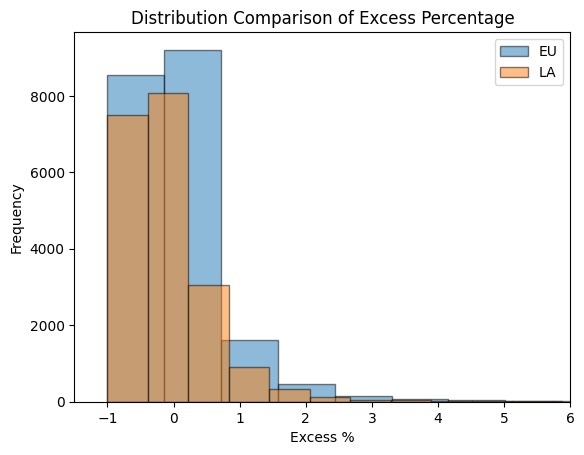

In [6]:
import matplotlib.pyplot as plt

df1_plot = pred_EU.dropna(subset=["excess_pct"])
df2_plot = pred_LA.dropna(subset=["excess_pct"])

plt.hist(df1_plot["excess_pct"], bins=20, alpha=0.5, label="EU", edgecolor="black")
plt.hist(df2_plot["excess_pct"], bins=20, alpha=0.5, label="LA", edgecolor="black")

plt.xlabel("Excess %")
plt.ylabel("Frequency")
plt.title("Distribution Comparison of Excess Percentage")
plt.xlim(-1.5, 6)

plt.legend()
plt.show()

In [34]:
import numpy as np
from cf_plus import penalty_report_from_cf

# Check out params after training:
rep = penalty_report_from_cf(model, return_deviance=True,
                             flows_df=flows, pop_df=pops, covid_df=None)
print(rep["groups_sq"])                # per-block squared norms
print("Penalty (sklearn):", rep["penalty_value_sklearn"])
print("Penalty (α * sum):", rep["penalty_value_alpha_sum"])
print("Train objective:",  rep.get("train_objective_value"))

{'||theta||^2': 1193.2257231767078, '||s||^2': 0.3685365977038367, 'beta_log_pop_o': 0.013206408966073451, 'beta_log_pop_d': 0.013206408966073451, 'gamma_Ht': 0.1269860107346609, 'delta_covid': 0.0}
Penalty (sklearn): 0.000596873829301539
Penalty (α * sum): 0.001193747658603078
Train objective: 205101.99992904207


/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/Prediction/cf_plus.py:320: RuntimeWarning: divide by zero encountered in log
  y * np.log(y / mu_safe) - (y - mu_safe),
/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/Prediction/cf_plus.py:320: RuntimeWarning: invalid value encountered in multiply
  y * np.log(y / mu_safe) - (y - mu_safe),


In [32]:
# Single corridor
corr = pred[(pred.orig=="CL")&(pred.dest=="US")].sort_values("month")
corr

,orig,dest,month,flow,mu_hat,excess_pct
4688,CL,US,2021-09-01,8111.0,1896.450828,3.276937
4689,CL,US,2021-10-01,6029.0,1894.544315,2.182296
4687,CL,US,2021-08-01,3814.0,1450.060328,1.630235
4701,CL,US,2022-10-01,5684.0,2389.035328,1.379203
4700,CL,US,2022-09-01,4325.0,1934.855442,1.235309
4690,CL,US,2021-11-01,3946.0,1892.853832,1.084683
4686,CL,US,2021-07-01,3240.0,1606.035691,1.017390
4703,CL,US,2022-12-01,5488.0,2774.304928,0.978153
4702,CL,US,2022-11-01,3640.0,1900.590032,0.915195
4691,CL,US,2021-12-01,2772.0,1517.448292,0.826751


# Plot

In [4]:
pred = pred_LA

In [13]:
pred_LA['orig'].unique()

array(['AR', 'BO', 'BR', 'CA', 'CL', 'CO', 'CR', 'DO', 'EC', 'ES', 'GY',
       'HT', 'MX', 'NI', 'PA', 'PE', 'PY', 'SR', 'US', 'UY', 'VE'],
      dtype=object)

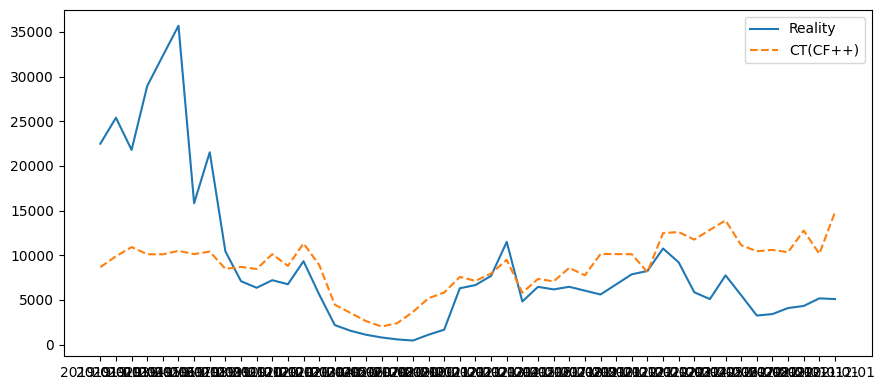

In [6]:
import matplotlib.pyplot as plt
# sub = pred[(pred.orig=="DE")&(pred.dest=="FR")].sort_values("month")
sub = pred[(pred.orig=="VE")&(pred.dest=="PE")].sort_values("month")
plt.figure(figsize=(9,4))
plt.plot(sub["month"], sub["flow"], label="Reality")
plt.plot(sub["month"], sub["mu_hat"], label="CT(CF++)", linestyle="--")
plt.legend(); plt.tight_layout(); plt.show()

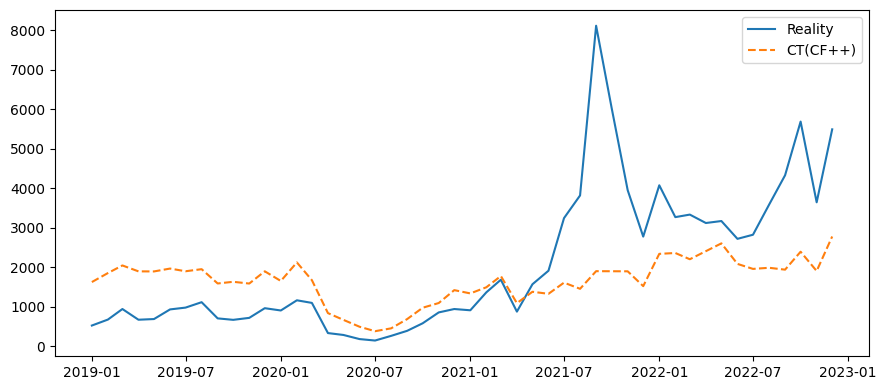

In [27]:
import matplotlib.pyplot as plt

sub = pred[(pred.orig=="CL")&(pred.dest=="US")].sort_values("month")
plt.figure(figsize=(9,4))
plt.plot(sub["month"], sub["flow"], label="Reality")
plt.plot(sub["month"], sub["mu_hat"], label="CT(CF++)", linestyle="--")
plt.legend(); plt.tight_layout(); plt.show()

In [15]:
from plot_triad import plot_pair_actual_vs_counterfactual

In [25]:
policies_CL = [
    ("2021-04-01", "Ley 21325 \nApril 2021", "red"),
    ("2021-03-01", "US Policy", "yellow")
]

policies_PE = [
    ("2019-07-15", "Visa Requirement\nJune 2019", "Red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2021-07-01", "Temporary Permit Carnet (CPT)\nJuly 2021", "green"),
    ("2021-10-22", "CPT Implementation\nOctober 2021", "red")
]

policies_EC = [
    ("2019-07-25", "Presidential Decree 826\nJuly 2019", "red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2019-08-26", "VIRTE\nBefore July 2019", "blue"),
    ("2022-06-01", "VIRTE\nSep 2022 to Aug 2023", "blue")
]

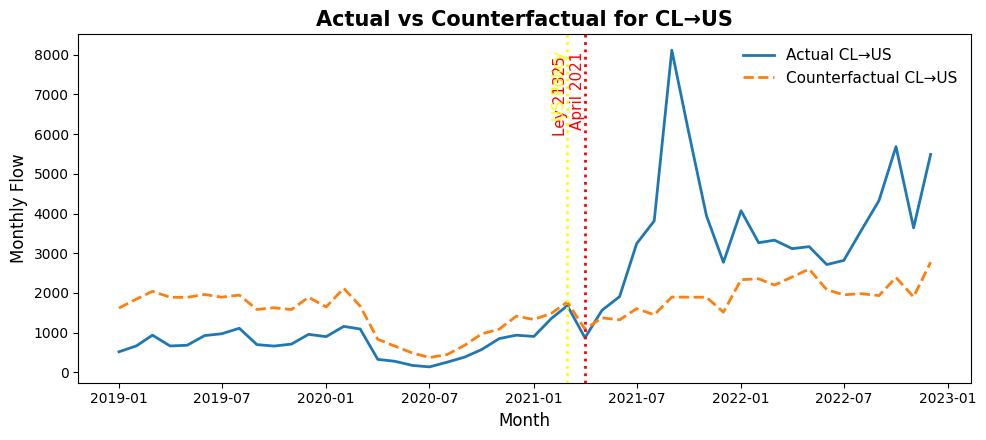

In [28]:
plot_pair_actual_vs_counterfactual(
    pred,
    orig="CL", dest="US",  
    policies=policies_CL,
    line_colors={"actual":"tab:blue", "counterfactual":"tab:orange"},
    yscale="linear"
)

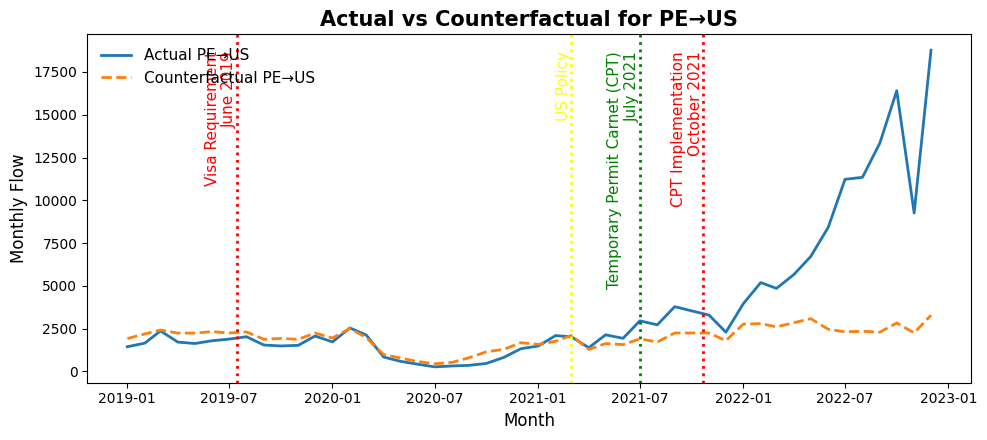

In [29]:
plot_pair_actual_vs_counterfactual(
    pred,
    orig="PE", dest="US", 
    policies=policies_PE,
    line_colors={"actual":"tab:blue", "counterfactual":"tab:orange"},
    yscale="linear"
)

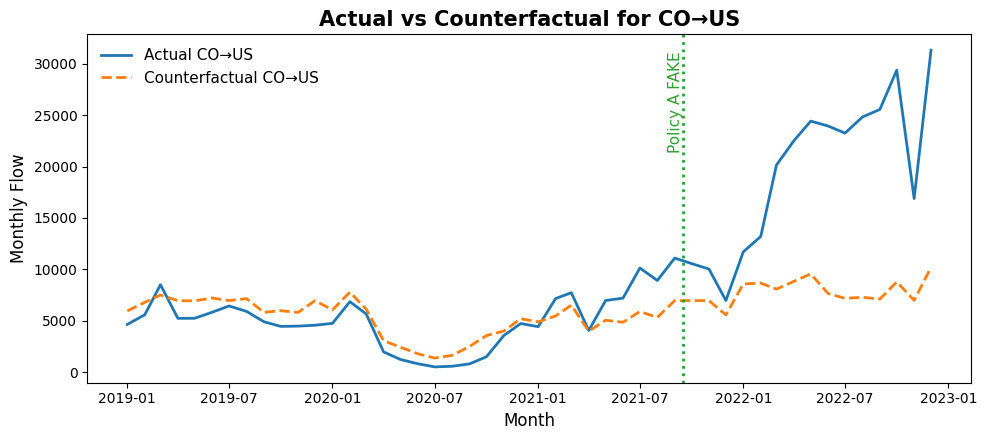

In [30]:
plot_pair_actual_vs_counterfactual(
    pred,
    orig="CO", dest="US", 
    policies=[("2021-09-15","Policy A FAKE","tab:green")],
    line_colors={"actual":"tab:blue", "counterfactual":"tab:orange"},
    yscale="linear"
)